# Solutions for block F

In [1]:
%matplotlib inline

import geopandas
import pandas
import esda
import seaborn as sns
from pysal.lib import weights
from splot.esda import moran_scatterplot, lisa_cluster
import matplotlib.pyplot as plt

## Task I

- Read geometries

In [2]:
p = ("Access_to_Healthy_Assets_and_Hazards_AHAH_E08000012/data/"\
     "Access_to_Healthy_Assets_and_Hazards_AHAH/"\
     "Local_Authority_Districts/"\
     "E08000012/shapefiles/E08000012.shp"
    )
lsoas = geopandas.read_file(p)

- Read AHAH

In [3]:
p = ("Access_to_Healthy_Assets_and_Hazards_AHAH_E08000012/data/"\
     "Access_to_Healthy_Assets_and_Hazards_AHAH/"\
     "Local_Authority_Districts/"\
     "E08000012/tables/E08000012.csv"
    )
ahah_data = pandas.read_csv(p)

- Merge both

In [4]:
ahah = lsoas.join(ahah_data.set_index("lsoa11cd"), on="lsoa11cd")\
            .set_index("lsoa11cd", drop=False)

- Create spatial weights

In [5]:
w = weights.Queen.from_dataframe(ahah, idVariable="lsoa11cd")

- Make sure your geography does not have islands

In [6]:
w.islands

[]

- Standardise the spatial weights matrix

In [7]:
w.transform = "R"

- Create the standardised version of the AHAH score

In [8]:
ahah['ahah_std'] = (ahah['ahah'] - ahah['ahah'].mean()) / ahah['ahah'].std()

- Create the spatial lag of the main AHAH score

In [9]:
ahah['ahah_lag'] = weights.lag_spatial(w, ahah['ahah_std'])

## Task II

- Moran Plot

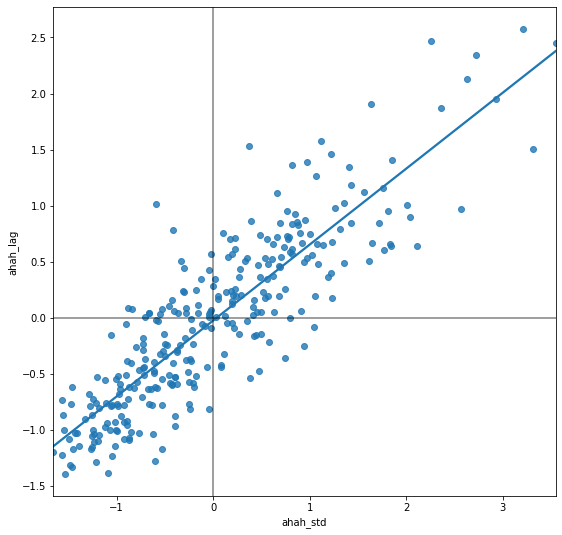

In [10]:
"""Visualise the main AHAH score with a Moran Plot"""
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='ahah_std', y='ahah_lag', data=ahah, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

- Calculate Moran’s I

In [11]:
mi = esda.Moran(ahah['ahah'], w)
print(mi.I)
print(f"P-value: {mi.p_sim}, or {mi.p_sim*100} percent.")

0.6770361378406533
P-value: 0.001, or 0.1 percent.


- What conclusions can you reach from the Moran Plot and Moran’s I? What’s the main spatial pattern?

> There is a clear case of statistically significant positive spatial autocorrelation, implying that similar values tend to be located geographically nearby

## Task III

- Calculate LISA statistics for the LSOA areas

In [12]:
lisa = esda.Moran_Local(ahah['ahah'], w)

- Make a map of significant clusters at the 5%

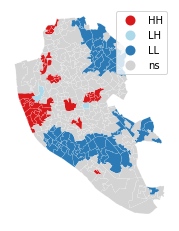

In [13]:
lisa_cluster(lisa, ahah, p=0.05);

- Can you identify hotspots or coldspots? If so, what do they mean? What about spatial outliers?

> There are two large clusters of coldspots, one in the south, one in the north-east; and one main hotspot in the nort-west section of the city, with other smaller ones largely in the north. Clusters can be interpreted as areas with a concentration of similar values that is beyond what one would expect from a random distribution. A few spatial outliers (light blue) can be observed adjacent to hotspots. These relate to areas where the similarity between themselves and their neighbors is much smaller than one would expect under spatial randomness.

- Create cluster maps for significance levels 1% and 10%; compare them with the one we obtained. What are the main changes? Why?

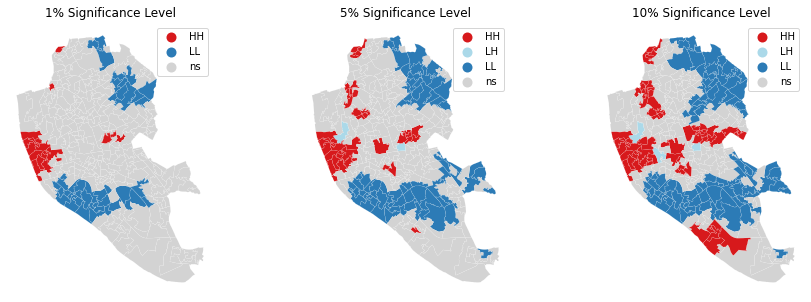

In [14]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
lisa_cluster(lisa, ahah, p=0.01, ax=axs[0])
axs[0].set_title("1% Significance Level")
lisa_cluster(lisa, ahah, p=0.05, ax=axs[1])
axs[1].set_title("5% Significance Level")
lisa_cluster(lisa, ahah, p=0.10, ax=axs[2])
axs[2].set_title("10% Significance Level");

> Stricter levels of significance impose a "higher bar" for a candidate cluster to be picked up as statistically significant. For that reason, everything that is significant at 1%, it also is at 10%, but not the other way around.